# Fashion Product Image Classifier

# Download data

In [1]:
import os
import zipfile
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
from glob import glob
from torchsummary import summary

# define data-dir
!mkdir -p ${HOME}/data
data_dir = f"{os.environ['HOME']}/data/fashion-products"

In [ ]:
#download and define yoour fashion-product-images-small.zip
fashion_product_zip_file = 'data/fashion-product-images-small.zip'
fashion_product_zip = zipfile.ZipFile(fashion_product_zip_file)
fashion_product_zip.extractall(data_dir)
fashion_product_zip.close()

In [2]:
print(os.listdir(data_dir))

['images', 'myntradataset', 'styles.csv', 'resize_images']


In [3]:
images_dir = f'{data_dir}/images'
styles_csv = f'{data_dir}/styles.csv'

# Resize images 

In [4]:
def resize_img(image_path, output_dir, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img,(size,size), interpolation = cv2.INTER_CUBIC)
    file_name = os.path.basename(image_path)
    cv2.imwrite(f'{output_dir}/{file_name}', img)

origin_images_dir = f'{data_dir}/images'
styles_csv = f'{data_dir}/styles.csv'
images_dir = f'{data_dir}/resize_images'

if not os.path.exists(images_dir):
    os.makedirs(images_dir)

origin_image_paths = np.array(glob(f"{origin_images_dir}/**"))
for origin_image_path in origin_image_paths:
    resize_img(origin_image_path, images_dir, 224)

# Exploration data

In [5]:
image_files = np.array(glob(f"{images_dir}/**"))
print('There are %d total fashion product images' % len(image_files))

There are 44441 total fashion product images


In [6]:
styles = pd.read_csv(styles_csv, error_bad_lines=False)
styles.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
import matplotlib.pyplot as plt
import cv2                
from random import randint

rand_style = styles.iloc[randint(0, len(styles))]
rand_style_image = cv2.imread(f"{images_dir}/{rand_style.id}.jpg")
plt.imshow(rand_style_image)
print(f"Style is {rand_style.articleType}")

Style is Dresses


In [8]:
rand_style_image.shape

(224, 224, 3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


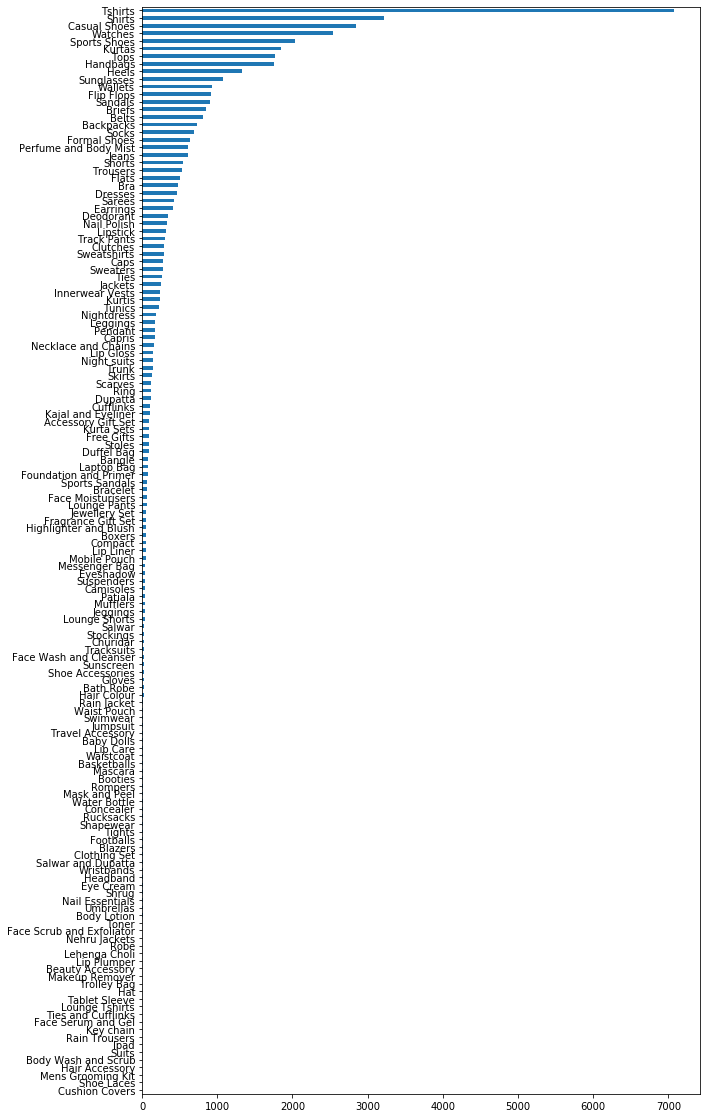

In [9]:
# Style Category Histogram
plt.figure(figsize=(10,20))
styles.articleType.value_counts().sort_values().plot('barh')

In [10]:
styles_filtered = styles.groupby('articleType').filter(lambda x: len(x) >= 50)

# Dataloader

In [11]:
import torch
from sklearn.model_selection import train_test_split
from skimage import io, transform
from torchvision import transforms, utils

def id_from_path(image_path):
    splitted = image_path.split('/')
    file_id_splitted = splitted[len(splitted) - 1].split('.')
    return int(file_id_splitted[len(file_id_splitted) - 2])

image_file_ids = [(id_from_path(x), x) for x in image_files]
image_file_ids_df = pd.DataFrame(image_file_ids, columns=['id', 'image_path'])
styles_with_paths = styles_filtered.merge(image_file_ids_df, how='left', on='id')
styles_with_paths = styles_with_paths[styles_with_paths.image_path.notnull()]

In [12]:
class FashionProductDataset(torch.utils.data.Dataset):
    def __init__(self, style_df, category_labels, transform=None):
        self.image_paths = style_df.image_path.to_numpy()
        self.labels = style_df.articleType.to_numpy()
        self.label2num = {label: i for i, label in enumerate(category_labels)}
        self.num2label = {i: label for i, label in enumerate(category_labels)}
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        im = Image.open(self.image_paths[idx]).convert('RGB')
        im = self.transform(im)
        
        im_label = self.labels[idx]
        im_label_num = self.label2num[im_label]
        
        return im, im_label_num

train_df, valid_df, test_df = np.split(styles_with_paths.sample(frac=1), 
                                          [int(.8*len(styles_with_paths)), int(.9*len(styles_with_paths))])

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

category_labels = np.unique(styles_with_paths.articleType.to_numpy())

train_ds = FashionProductDataset(train_df, category_labels, transform = train_transforms)
valid_ds = FashionProductDataset(valid_df, category_labels, transform = valid_transforms)
test_ds = FashionProductDataset(test_df, category_labels, transform = valid_transforms)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_ds,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

valid_loader = torch.utils.data.DataLoader(valid_ds,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

test_loader = torch.utils.data.DataLoader(test_ds,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)

loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


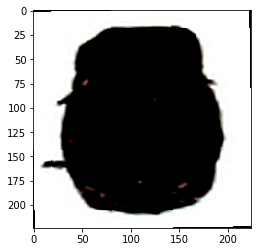

In [13]:
idx = 7
plt.imshow(np.transpose(train_ds[idx][0].numpy(), (1, 2, 0)))

In [14]:
len(styles)

44424

In [16]:
n_outputs = len(category_labels)

In [17]:
print(n_outputs)

70


# Simple CNN Model

In [22]:
from PIL import Image
import torch.nn.functional as F

class SimpleCNNModel(torch.nn.Module):
    def __init__(self, n_outputs):
        super(SimpleCNNModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.conv4 = torch.nn.Conv2d(128, 64, 3)
        
        self.fc1 = torch.nn.Linear(64*12*12, 512)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, n_outputs)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool1(F.relu(self.conv3(x)))
        x = self.pool1(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
summary(SimpleCNNModel(n_outputs).to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
         MaxPool2d-2         [-1, 32, 110, 110]               0
            Conv2d-3         [-1, 64, 108, 108]          18,496
         MaxPool2d-4           [-1, 64, 54, 54]               0
            Conv2d-5          [-1, 128, 52, 52]          73,856
         MaxPool2d-6          [-1, 128, 26, 26]               0
            Conv2d-7           [-1, 64, 24, 24]          73,792
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Linear-9                  [-1, 512]       4,719,104
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                   [-1, 70]          17,990
Total params: 5,036,998
Trainable params: 5,036,998
Non-trainable params: 0
---------------------------

# Training Functions

In [24]:
from livelossplot import PlotLosses
import time
import sys

def train(model, loaders, criterion, optimizer, scheduler, n_epochs, save_path, seed=777):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_history = []
    # for reproducibility
    torch.manual_seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed_all(seed)
    
    since = time.time()
    liveloss = PlotLosses()
    valid_loss_min = np.Inf 
    
    for epoch in range(n_epochs):        
        train_size, valid_size = 0, 0        
        train_loss, valid_loss = 0.0, 0.0
        train_corrects, valid_corrects = 0, 0
        
        # training
        scheduler.step()
        model.train()
        for batch_idx, (X, Y) in enumerate(loaders['train']):
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            _, preds = torch.max(output, 1)
            loss = criterion(output, Y)    
            loss.backward()
            optimizer.step()
            
            train_size += Y.size(0)            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_corrects += torch.sum(preds == Y.data)
            
        model.eval()
        for batch_idx, (X, Y) in enumerate(loaders['valid']):
            X, Y = X.to(device), Y.to(device)
            with torch.no_grad():
                output = model(X)
            
            _, preds = torch.max(output, 1)
            loss = criterion(output, Y)
            
            valid_size += Y.size(0)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            valid_corrects += torch.sum(preds == Y.data)


        train_accuracy = train_corrects.double() / train_size
        valid_accuracy = valid_corrects.double() / valid_size
        
        print('Epoch: {} ||| Train Loss: {:.6f}, Accuracy: {:.4f}  ||| Valid Loss: {:.6f}, Accuracy: {:.4f}'.format(
            epoch, 
            train_loss, train_accuracy,
            valid_loss, valid_accuracy,
            ))
        
        if save_path != None and valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        liveloss.update({
            'log loss': train_loss,
            'val_log loss': valid_loss,
            'accuracy': train_accuracy,
            'val_accuracy': valid_accuracy
        })
        
        train_history.append({
            'epoch': epoch,
            
            'train_loss': train_loss.item(),
            'train_size': train_size,
            'train_corrects': train_corrects.double().item(),
            'train_accuracy': train_accuracy.item(),
            
            'val_loss': valid_loss.item(),
            'val_size': valid_size,
            'val_corrects': valid_corrects.double().item(),
            'val_accuracy': valid_accuracy.item() 
        })         
    
    time_elapsed = time.time() - since
    return model, liveloss, train_history, time_elapsed

In [36]:
import torchvision.models as models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
    
def batch_norm_and_dropout(n_inputs, n_outputs, n_mids=256):
    keep_prob = 0.5
    fc1 = torch.nn.Linear(n_inputs, n_mids, bias=True)
    torch.nn.init.xavier_uniform_(fc1.weight)
    layer1 = torch.nn.Sequential(fc1,
                                      torch.nn.BatchNorm1d(n_mids),
                                      torch.nn.ReLU(),
                                      torch.nn.Dropout(p=1 - keep_prob))

    fc2 = torch.nn.Linear(n_mids, n_outputs, bias=True)
    torch.nn.init.xavier_uniform_(fc2.weight)  

    return torch.nn.Sequential(layer1, fc2)

def simple_fc(n_inputs, n_outputs, n_mids=None):
    fc = torch.nn.Linear(n_inputs, n_outputs)
    torch.nn.init.xavier_uniform_(fc.weight)
    return fc

def training_models(model_name, 
                    n_outputs, 
                    pretrain_last_layer=None):
    # simple cnn model
    model = None
    if model_name == 'simple':
        model = SimpleCNNModel(n_outputs)
        model.to(device)
        return model

    # pretrain model
    last_layer_idx = None
    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        last_layer_idx = 1
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        last_layer_idx = 6


    if pretrain_last_layer is not None:
        last_layer_fn = None
        if pretrain_last_layer is 'fc':
            last_layer_fn = simple_fc
        elif pretrain_last_layer is 'batchnorm':
            last_layer_fn = batch_norm_and_dropout

        # freezing
        for param in model.features.parameters():
            param.require_grad = False

        n_inputs = model.classifier[last_layer_idx].in_features
        model.classifier[last_layer_idx] = last_layer_fn(n_inputs, n_outputs)
    else:
        n_inputs = model.classifier[last_layer_idx].in_features
        model.classifier[last_layer_idx] = simple_fc(n_inputs, n_outputs)        
        
    model.to(device)
    return model

def train_model(model_name, #simple, mobilenet_v2, vgg16
                loaders,
                n_outputs,
                pretrain_last_layer, # None, fc, batchnorm
                learning_rate, 
                optimizer_fn, # adam or sgd
                n_epochs=20):
    print(f"""
##################################################################
Start Training
model_name = {model_name}
pretrain_last_layer = {pretrain_last_layer}
learning_rate = {learning_rate}
optimizer_fn = {optimizer_fn}
##################################################################
    """)
    model = training_models(model_name, n_outputs, pretrain_last_layer)
    
    if optimizer_fn == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_fn == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    criterion = torch.nn.CrossEntropyLoss().to(device)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
    
    save_path = None
    model, model_liveloss, model_history, model_training_time = train(model, 
                                                                      loaders, 
                                                                      criterion,
                                                                      optimizer,
                                                                      scheduler,
                                                                      n_epochs,
                                                                      save_path)
    print(f"Training End : model training time : {model_training_time}")
    return {
        # model
        'model': model,
        
        # hyperparams
        'last_layer': pretrain_last_layer,
        'learning_rate': learning_rate,
        'optimizer': optimizer_fn,
        
        # result
        'liveloss': model_liveloss,
        'history': model_history,
        'training_time': model_training_time
    }

In [37]:
# hyperparameters

optimizer_fn_params = ['adam', 'sgd']
pretrain_models = ['mobilenet_v2', 'vgg16']
pretrain_last_layers = ['fc', 'batchnorm']
learning_rates = [0.1, 0.01, 0.001]

# Hyperparameter Test

In [35]:
test_simple_model_training_results = []
test_pretrain_model_training_results = []
n_epochs = 3

# training simple models
for lr in learning_rates:
    for opt_fn in optimizer_fn_params:
        result = train_model(model_name = 'simple',
                                          loaders = loaders,
                                          n_outputs = n_outputs,
                                          pretrain_last_layer = None, # simple not need
                                          learning_rate = lr,
                                          optimizer_fn = opt_fn,
                                          n_epochs = n_epochs)
        
        test_simple_model_training_results.append(result)

# training pretrain models
for lr in learning_rates:
    for opt_fn in optimizer_fn_params:
        for pretrain_model_name in pretrain_models:
            for pretrain_last_layer in pretrain_last_layers:
                result = train_model(model_name = pretrain_model_name,
                                                  loaders = loaders,
                                                  n_outputs = n_outputs,
                                                  pretrain_last_layer = pretrain_last_layer,
                                                  learning_rate = lr,
                                                  optimizer_fn = opt_fn,
                                                  n_epochs = n_epochs)

                test_pretrain_model_training_results.append(result)        


##################################################################
Start Training
model_name = simple
pretrain_last_layer = None
learning_rate = 0.1
optimizer_fn = adam
##################################################################
    


NameError: name 'lr_scheduler' is not defined

In [490]:
test_simple_results_summary = [{'model': x['model'].__class__.__name__,
  'optimizer': x['optimizer'],
  'learning_rate': x['learning_rate'],
  'val_loss': x['history'][2]['val_loss'],
  'train_loss': x['history'][2]['train_loss'],
  'val_accuracy': x['history'][2]['val_accuracy'],
  'train_accuracy': x['history'][2]['train_accuracy']
 } for x in test_simple_model_training_results]

test_simple_results_summary.sort(key=lambda x: x['val_loss'])
pd.DataFrame(test_simple_results_summary).head(10)

,model,optimizer,learning_rate,val_loss,train_loss,val_accuracy,train_accuracy
0,SimpleCNNModel,adam,0.001,0.641023,0.820556,0.796215,0.744706
1,SimpleCNNModel,sgd,0.100,0.730281,0.906727,0.765059,0.716173
2,SimpleCNNModel,adam,0.010,1.485449,1.951575,0.556889,0.466851
3,SimpleCNNModel,sgd,0.010,1.515034,1.803263,0.516963,0.458225
4,SimpleCNNModel,sgd,0.001,3.484331,3.637628,0.157628,0.162512
5,SimpleCNNModel,adam,0.100,3.531939,3.510383,0.157628,0.162714


In [488]:
test_pretrain_results_summary = [{'model': x['model'].__class__.__name__,
  'last_layer': x['last_layer'],
  'optimizer': x['optimizer'],
  'learning_rate': x['learning_rate'],
  'val_loss': x['history'][2]['val_loss'],
  'train_loss': x['history'][2]['train_loss'],
  'val_accuracy': x['history'][2]['val_accuracy'],
  'train_accuracy': x['history'][2]['train_accuracy']
 } for x in test_pretrain_model_training_results]

test_pretrain_results_summary.sort(key=lambda x: x['val_loss'])
pd.DataFrame(test_pretrain_results_summary).head(10)

,model,last_layer,optimizer,learning_rate,val_loss,train_loss,val_accuracy,train_accuracy
0,MobileNetV2,fc,sgd,0.010,0.420283,0.420684,0.863605,0.866857
1,VGG,fc,sgd,0.010,0.421817,0.450241,0.862682,0.854798
2,VGG,batchnorm,sgd,0.100,0.439283,0.465499,0.855989,0.854250
3,MobileNetV2,fc,sgd,0.100,0.471964,0.363651,0.847911,0.876608
4,MobileNetV2,batchnorm,sgd,0.100,0.474998,0.463525,0.840988,0.854509
5,MobileNetV2,batchnorm,adam,0.001,0.527719,0.507040,0.833141,0.839998
6,MobileNetV2,batchnorm,sgd,0.010,0.536724,0.641226,0.842603,0.825111
7,VGG,batchnorm,sgd,0.010,0.543662,0.694667,0.830141,0.810888
8,MobileNetV2,fc,adam,0.001,0.546890,0.427327,0.831526,0.857740
9,VGG,batchnorm,adam,0.001,0.648494,0.795218,0.786753,0.755236


# Final Model Training

In [43]:
# Final Model Training
n_epochs = 10

In [44]:
# Simple CNN Model
# learning rate = 0.001
# optimizer = adam
simple_cnn_model_final = train_model(model_name = 'simple',
                                  loaders = loaders,
                                  n_outputs = n_outputs,
                                  pretrain_last_layer = None, # simple not need
                                  learning_rate = 0.001,
                                  optimizer_fn = 'adam',
                                  n_epochs = n_epochs)


##################################################################
Start Training
model_name = simple
pretrain_last_layer = None
learning_rate = 0.001
optimizer_fn = adam
##################################################################
    
Epoch: 0 ||| Train Loss: 1.953356, Accuracy: 0.4671  ||| Valid Loss: 1.011309, Accuracy: 0.6926
Epoch: 1 ||| Train Loss: 1.046260, Accuracy: 0.6794  ||| Valid Loss: 0.833185, Accuracy: 0.7473
Epoch: 2 ||| Train Loss: 0.880603, Accuracy: 0.7231  ||| Valid Loss: 0.710629, Accuracy: 0.7780
Epoch: 3 ||| Train Loss: 0.780468, Accuracy: 0.7530  ||| Valid Loss: 0.651136, Accuracy: 0.7985
Epoch: 4 ||| Train Loss: 0.708227, Accuracy: 0.7695  ||| Valid Loss: 0.597867, Accuracy: 0.8066
Epoch: 5 ||| Train Loss: 0.660644, Accuracy: 0.7862  ||| Valid Loss: 0.582932, Accuracy: 0.8144
Epoch: 6 ||| Train Loss: 0.554140, Accuracy: 0.8177  ||| Valid Loss: 0.524512, Accuracy: 0.8281
Epoch: 7 ||| Train Loss: 0.523549, Accuracy: 0.8271  ||| Valid Loss: 0.519702, Accur

In [45]:
# Final Transfer Learning Model Training
pretrain_model_training_results_final = []

for pretrain_model_name in pretrain_models:
    for pretrain_last_layer in pretrain_last_layers:
        result = train_model(model_name = pretrain_model_name,
                                          loaders = loaders,
                                          n_outputs = n_outputs,
                                          pretrain_last_layer = pretrain_last_layer,
                                          learning_rate = 0.010,
                                          optimizer_fn = 'sgd',
                                          n_epochs = n_epochs)

        pretrain_model_training_results_final.append(result)    


##################################################################
Start Training
model_name = mobilenet_v2
pretrain_last_layer = fc
learning_rate = 0.01
optimizer_fn = sgd
##################################################################
    
Epoch: 0 ||| Train Loss: 1.049991, Accuracy: 0.7238  ||| Valid Loss: 0.602080, Accuracy: 0.8204
Epoch: 1 ||| Train Loss: 0.519693, Accuracy: 0.8400  ||| Valid Loss: 0.489021, Accuracy: 0.8456
Epoch: 2 ||| Train Loss: 0.416059, Accuracy: 0.8656  ||| Valid Loss: 0.435611, Accuracy: 0.8715
Epoch: 3 ||| Train Loss: 0.362538, Accuracy: 0.8823  ||| Valid Loss: 0.395008, Accuracy: 0.8802
Epoch: 4 ||| Train Loss: 0.319090, Accuracy: 0.8950  ||| Valid Loss: 0.378394, Accuracy: 0.8839
Epoch: 5 ||| Train Loss: 0.287863, Accuracy: 0.9050  ||| Valid Loss: 0.372204, Accuracy: 0.8830
Epoch: 6 ||| Train Loss: 0.235361, Accuracy: 0.9226  ||| Valid Loss: 0.338950, Accuracy: 0.8971
Epoch: 7 ||| Train Loss: 0.223702, Accuracy: 0.9263  ||| Valid Loss: 0.336814, Acc

In [57]:
training_results_final = [simple_cnn_model_final] + pretrain_model_training_results_final

,model,last_layer,optimizer,learning_rate,val_loss,train_loss,val_accuracy,train_accuracy
0,SimpleCNNModel,None,adam,0.001,0.505430,0.494118,0.836141,0.835064
1,MobileNetV2,fc,sgd,0.010,0.333457,0.215609,0.897531,0.929952
2,MobileNetV2,batchnorm,sgd,0.010,0.352437,0.353046,0.889453,0.894409
3,VGG,fc,sgd,0.010,0.344832,0.233365,0.897531,0.920518
4,VGG,batchnorm,sgd,0.010,0.380912,0.393231,0.883453,0.883850


In [111]:
from sklearn import metrics


def predict_test(model, device, criterion, loaders):
    model.eval()

    test_loss = 0.
    correct = 0.
    total = 0.
    
    actuals = []
    predictions = []
    with torch.no_grad():
        for batch_idx, (X, Y) in enumerate(loaders['test']):
            X, Y = X.to(device), Y.to(device)
            output = model(X)
                                           
            loss = criterion(output, Y)
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))

            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(Y.view_as(prediction))
            predictions.extend(prediction)
            
    return [i.item() for i in actuals], [i.item() for i in predictions], test_loss

def evaluate_model(model, device, loaders):
    criterion = torch.nn.CrossEntropyLoss().to(device)
    actuals, predictions, loss = predict_test(model, device, criterion, loaders)
    
    f1_score = metrics.f1_score(actuals, predictions, average='weighted')
    accuracy_score = metrics.accuracy_score(actuals, predictions)
    precision_score = metrics.precision_score(actuals, predictions, average='weighted')
    recall_score = metrics.recall_score(actuals, predictions, average='weighted')
    
    return accuracy_score, precision_score, recall_score, f1_score, loss

In [112]:
training_results_final_summary = []
for x in training_results_final:
    accuracy_score, precision_score, recall_score, f1_score, loss = evaluate_model(x['model'], device, loaders)
    
    final_summary = {'model': x['model'].__class__.__name__,
      'last_layer': x['last_layer'],
      'optimizer': x['optimizer'],
      'learning_rate': x['learning_rate'],
      'val_loss': x['history'][9]['val_loss'],
      'train_loss': x['history'][9]['train_loss'],
      'test_loss': loss.item(),
      'val_accuracy': x['history'][9]['val_accuracy'],
      'train_accuracy': x['history'][9]['train_accuracy'],
      'test_accuracy': accuracy_score,
      'test_precision': precision_score,
      'test_recall': recall_score,
      'test_f1': f1_score
     }
    training_results_final_summary.append(final_summary)
    

In [127]:
final_summary_pd = pd.DataFrame(training_results_final_summary)

In [128]:
final_summary_pd[['model', 'last_layer', 'train_loss', 'val_loss', 'test_loss', 'train_accuracy', 'val_accuracy', 'test_accuracy', 'test_f1']]

,model,last_layer,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy,test_f1
0,SimpleCNNModel,None,0.494118,0.505430,0.463561,0.835064,0.836141,0.846988,0.839673
1,MobileNetV2,fc,0.215609,0.333457,0.318236,0.929952,0.897531,0.897531,0.892878
2,MobileNetV2,batchnorm,0.353046,0.352437,0.346089,0.894409,0.889453,0.888761,0.882110
3,VGG,fc,0.233365,0.344832,0.313034,0.920518,0.897531,0.899838,0.896501
4,VGG,batchnorm,0.393231,0.380912,0.369678,0.883850,0.883453,0.883222,0.871237


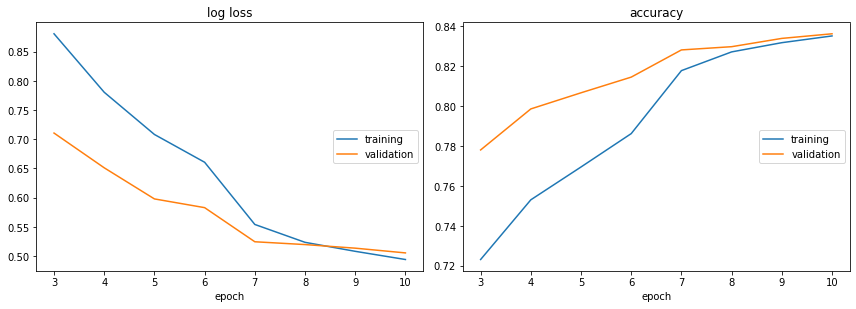

log loss:
training   (min:    0.494, max:    1.953, cur:    0.494)
validation (min:    0.505, max:    1.011, cur:    0.505)

accuracy:
training   (min:    0.467, max:    0.835, cur:    0.835)
validation (min:    0.693, max:    0.836, cur:    0.836)


In [122]:
# SimpleCNNModel
training_results_final[0]['liveloss'].draw()

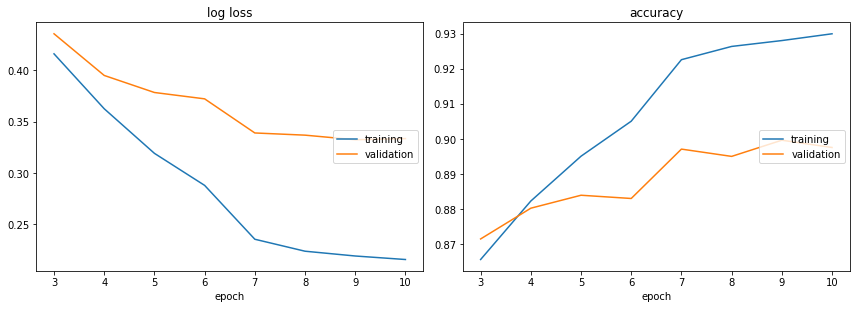

log loss:
training   (min:    0.216, max:    1.050, cur:    0.216)
validation (min:    0.332, max:    0.602, cur:    0.333)

accuracy:
training   (min:    0.724, max:    0.930, cur:    0.930)
validation (min:    0.820, max:    0.900, cur:    0.898)


In [123]:
# MobileNetV2 + fc
training_results_final[1]['liveloss'].draw()

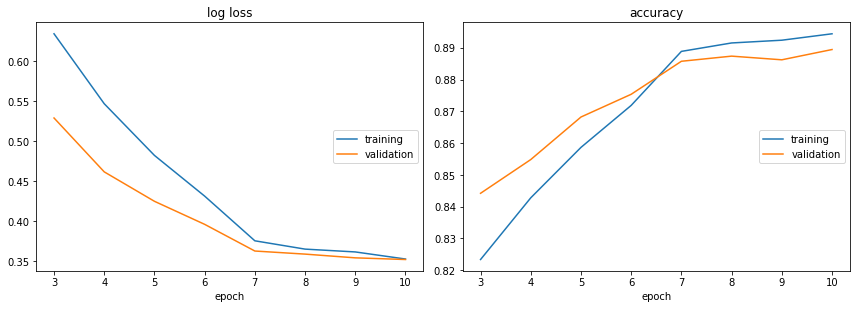

log loss:
training   (min:    0.353, max:    1.514, cur:    0.353)
validation (min:    0.352, max:    0.794, cur:    0.352)

accuracy:
training   (min:    0.636, max:    0.894, cur:    0.894)
validation (min:    0.789, max:    0.889, cur:    0.889)


In [124]:
# MobileNetV2 + batchnorm
training_results_final[2]['liveloss'].draw()

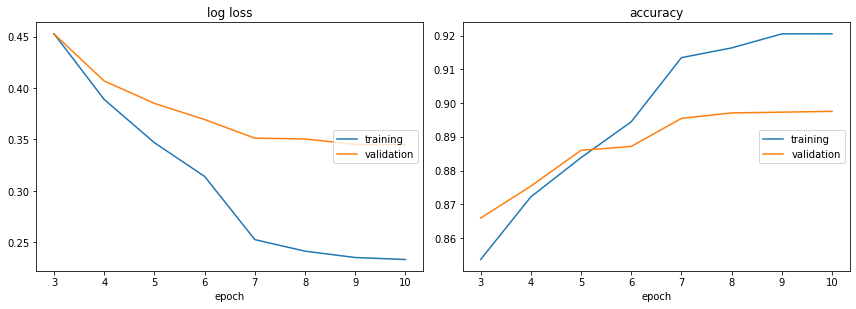

log loss:
training   (min:    0.233, max:    1.062, cur:    0.233)
validation (min:    0.345, max:    0.566, cur:    0.345)

accuracy:
training   (min:    0.710, max:    0.921, cur:    0.921)
validation (min:    0.828, max:    0.898, cur:    0.898)


In [125]:
# VGG16 + fc
training_results_final[3]['liveloss'].draw()

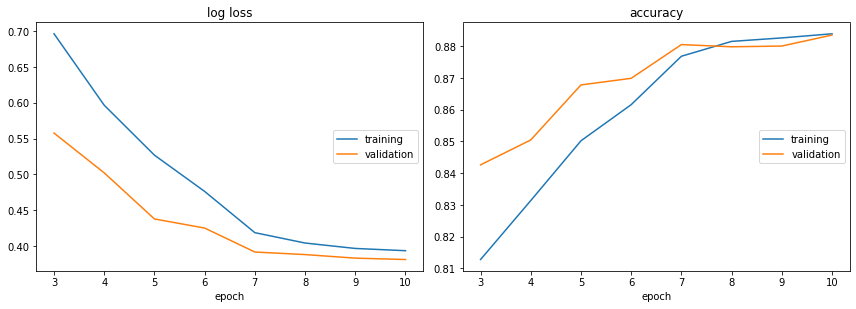

log loss:
training   (min:    0.393, max:    1.659, cur:    0.393)
validation (min:    0.381, max:    0.874, cur:    0.381)

accuracy:
training   (min:    0.607, max:    0.884, cur:    0.884)
validation (min:    0.771, max:    0.883, cur:    0.883)


In [126]:
# VGG16 + batchnorm4
training_results_final[4]['liveloss'].draw()

# Test images

In [167]:
from PIL import Image
import torchvision.transforms as transforms

def predict_product_image_probs(model, img_path, top_n=10):
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5],
                                                         [0.5, 0.5, 0.5])])

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    
    model.eval()
    out = model(batch_t.to(device))
    softmax = nn.Softmax(dim=1)
    preds = softmax(out)
    return torch.topk(preds, top_n)

def predict_product_image(model, img_path, top_n=10):
    # load the image and return the predicted breed
    preds = predict_product_image_probs(model, img_path, top_n=top_n) 
    probs = preds[0][0].data.cpu().numpy()
    class_idxs = preds[1][0].data.cpu().numpy()
    
    return [(category_labels[class_idx], prob) for class_idx, prob in zip(class_idxs, probs)]

def display_image(img_path):
    # Display image
    img = Image.open(img_path)
    _, ax = plt.subplots()
    ax.imshow(img)
    plt.axis('off')
    plt.show()
    

def show_predict_product_image(model, img_path):
    ## handle cases for a human face, dog, and neither
    predicted_classes = predict_product_image(model, img_path)
    top1_class, top1_prob = predicted_classes[0]
    print("{}, Probability : {:2f}%".format(top1_class, 100 * top1_prob))
    display_image(img_path)

Watches, Probability : 98.858529%


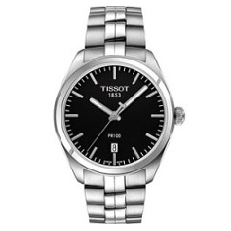

Watches, Probability : 99.806350%


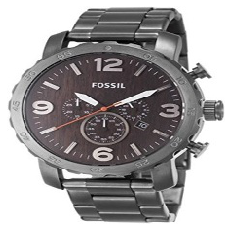

Casual Shoes, Probability : 61.639512%


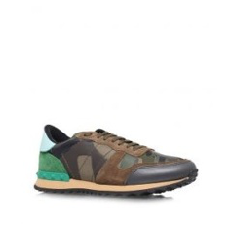

Sports Shoes, Probability : 88.512039%


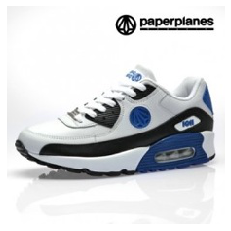

Flats, Probability : 26.946574%


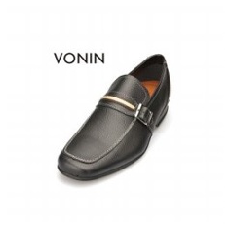

Casual Shoes, Probability : 43.126324%


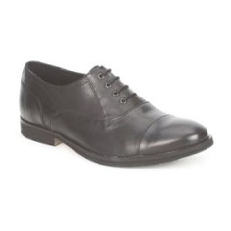

Backpacks, Probability : 16.617109%


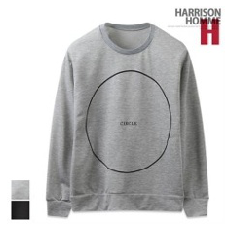

Watches, Probability : 60.153788%


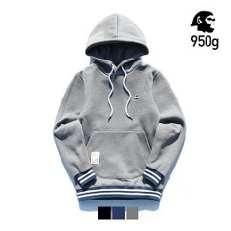

Shirts, Probability : 46.777847%


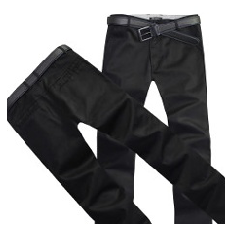

Shorts, Probability : 94.357479%


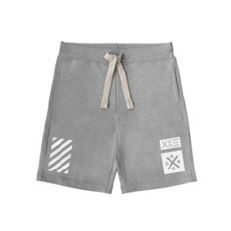

In [193]:
test_model.eval()
for img in np.array(glob(f"./test/**")):
    show_predict_product_image(test_model, img)

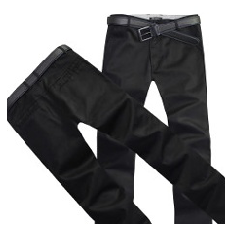

In [196]:
display_image('./test/2.jpg')

In [197]:
predict_product_image(test_model, './test/2.jpg')

[('Shirts', 0.46777847),
 ('Scarves', 0.10490554),
 ('Bra', 0.06707388),
 ('Socks', 0.046032753),
 ('Shorts', 0.036568534),
 ('Free Gifts', 0.0270993),
 ('Jeans', 0.024386266),
 ('Briefs', 0.020216145),
 ('Trousers', 0.019899927),
 ('Jackets', 0.019069292)]